# **Cluster Analysis**

In [178]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [179]:
try:
    df = pd.read_pickle('resources/pickle_files/charging_sessions_prepared.pkl')
    print("Successfully imported charging_sessions_prepared.pkl")
except FileNotFoundError:
    print("Error: charging_sessions_prepared.pkl not found.")

Successfully imported charging_sessions_prepared.pkl


We try to find some clusters which represent archetypical charging events. For this, we need to decide on good features on which we construct the clusters after (which should also not be too big because of the Curse of Dimensionality). After lots of discussion and many iterations of trying out different combinations, we came to the conclusion that our most important features for the Cluster Analysis are **kWhDelivered**, **connectionDuration** as well as **chargingDuration**.

In [180]:
cluster_df = df[['kWhDelivered', 'chargingDuration', 'connectionDuration']]

We first decided on using k-means as our clustering algorithm. For that, we need to normalize our input features.

In [181]:
scaler = StandardScaler()
cluster_df = scaler.fit_transform(cluster_df)

To decide on our k, the number of clusters, for our algorithm, we will use the elbow method.

In [182]:
clusters = []
losses = []

K = range(1, 16)
for k in K:
    model = KMeans(n_clusters=k, n_init='auto', random_state=42)
    model.fit(cluster_df)
    clusters.append(k)
    losses.append(model.inertia_)

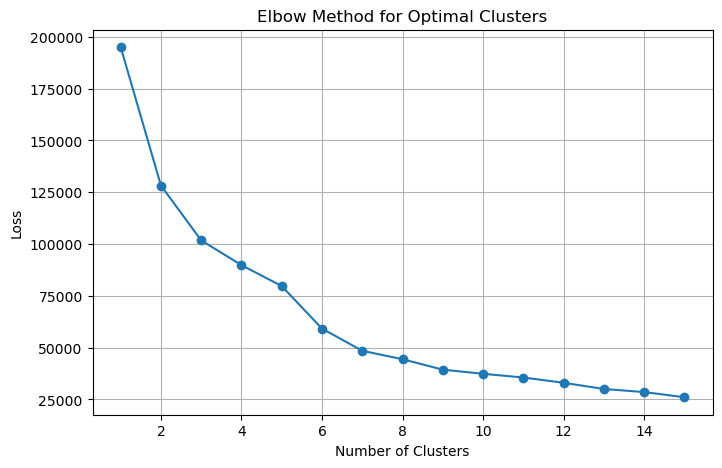

In [183]:
plt.figure(figsize=(8, 5))
plt.plot(clusters, losses, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

Let's zoom in a bit!

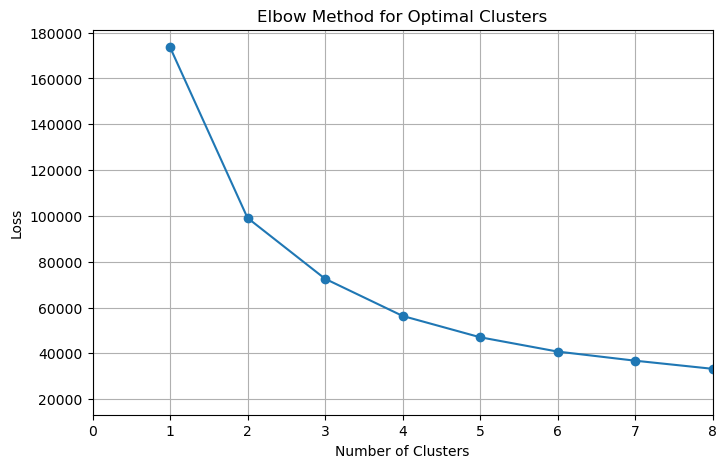

In [191]:
plt.figure(figsize=(8, 5))
plt.plot(clusters, losses, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Loss')
plt.xlim([0,8])
plt.grid(True)
plt.show()

We can observe that we should expect a 'good' clustering by choosing the number of clusters to be somewhere between (and including) 2 and 6. We want an appropriate trade-off between explainability and information content, thus we have decided on moving on with **3** clusters! We now plot what those three clusters would look like:

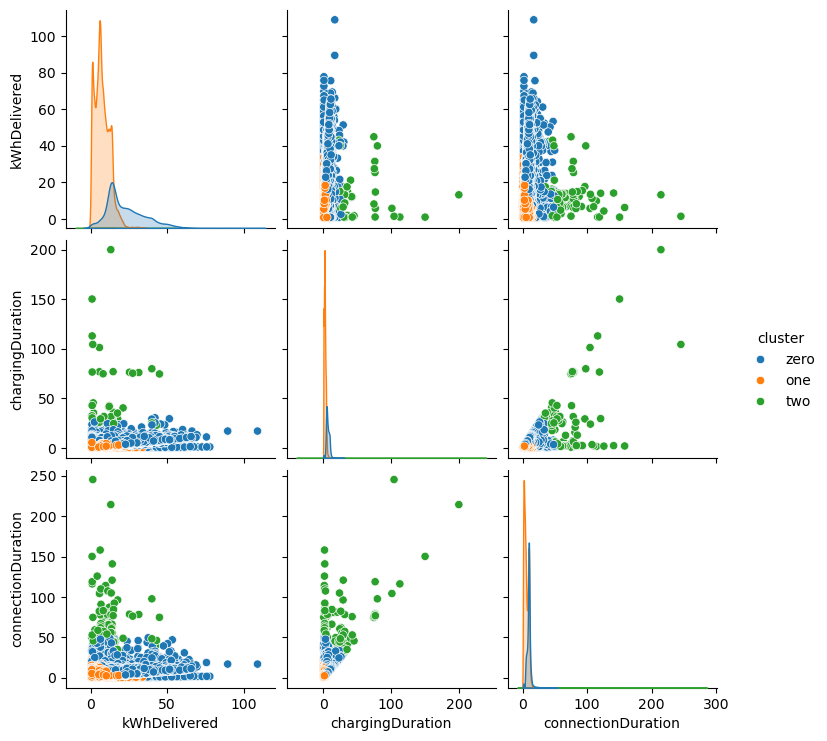

In [185]:
numbers = ["zero", "one", "two", "three"]
three_means = KMeans(n_clusters=3, n_init='auto')
three_means.fit(cluster_df)
df["cluster"] = three_means.predict(cluster_df)
df["cluster"] = df["cluster"].apply(lambda x: numbers[x])
sns.pairplot(data=df[['kWhDelivered', 'chargingDuration', 'connectionDuration', 'cluster']], hue="cluster")
plt.show()

We observe that our data contains outliers / extreme values which heavily influence the result of the k-means algorithm. To account for that, we will remove them by using the IQR (interquantile range) method.

In [186]:
Q1 = df[['kWhDelivered', 'chargingDuration', 'connectionDuration']].quantile(0.25)
Q3 = df[['kWhDelivered', 'chargingDuration', 'connectionDuration']].quantile(0.75)
IQR = Q3 - Q1

filtered_df = df[~(
    (df[['kWhDelivered', 'chargingDuration', 'connectionDuration']] < (Q1 - 1.5 * IQR)) |
    (df[['kWhDelivered', 'chargingDuration', 'connectionDuration']] > (Q3 + 1.5 * IQR))
).any(axis=1)][['kWhDelivered', 'chargingDuration', 'connectionDuration']]

We now proceed as before:

In [187]:
cluster_df = filtered_df[['kWhDelivered', 'chargingDuration', 'connectionDuration']]
scaler = StandardScaler()
cluster_df = scaler.fit_transform(cluster_df)

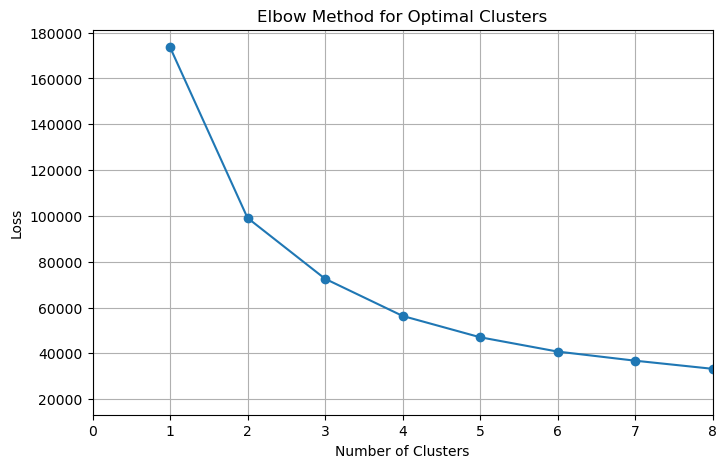

In [188]:
clusters = []
losses = []

K = range(1, 16)
for k in K:
    model = KMeans(n_clusters=k, n_init='auto', random_state=42)
    model.fit(cluster_df)
    clusters.append(k)
    losses.append(model.inertia_)


plt.figure(figsize=(8, 5))
plt.plot(clusters, losses, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Loss')
plt.xlim([0,8])
plt.grid(True)
plt.show()

With the same argument as before, we stick with **3** clusters. Now we look at the plots again:

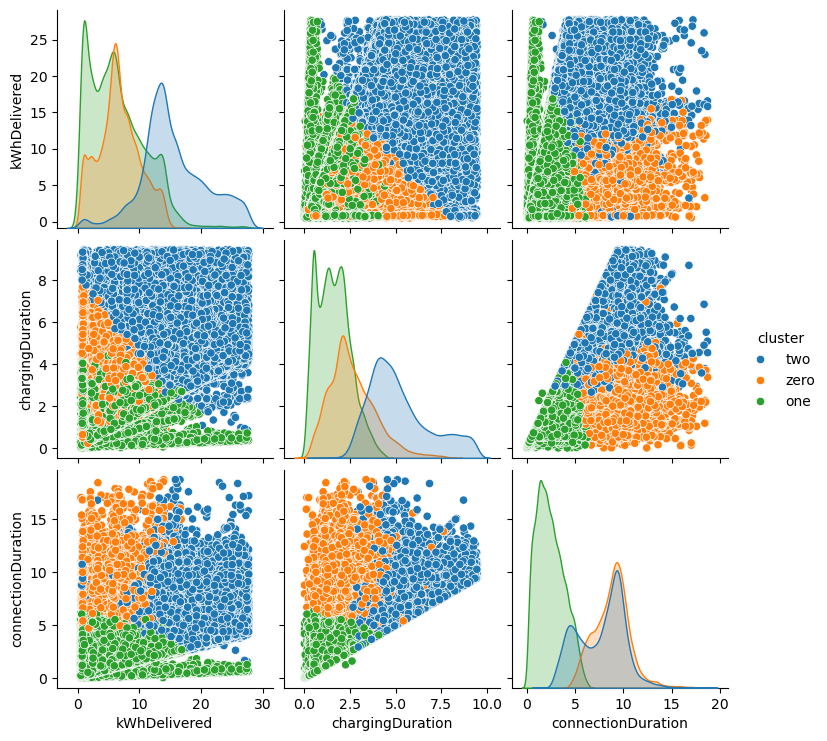

In [189]:
three_means.fit(cluster_df)
filtered_df["cluster"] = three_means.predict(cluster_df)
filtered_df["cluster"] = filtered_df["cluster"].apply(lambda x: numbers[x])
sns.pairplot(data=filtered_df[['kWhDelivered', 'chargingDuration', 'connectionDuration', 'cluster']], hue="cluster")
plt.show()

We see that we achieve a visible clustering where we can distinguish the clusters easily. Let's take a closer look:

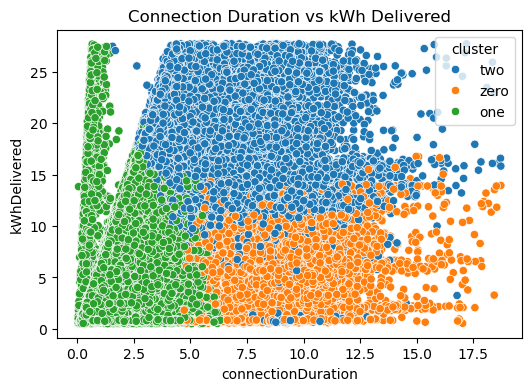

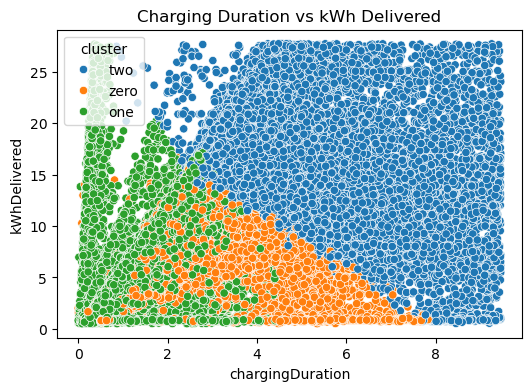

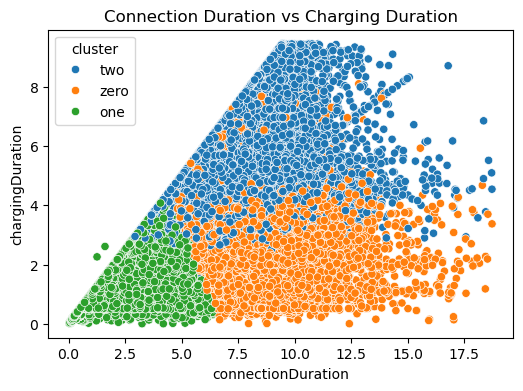

In [190]:
plt.figure(figsize=(6, 4))
sns.scatterplot(data=filtered_df, x="connectionDuration", y="kWhDelivered", hue="cluster")
plt.title("Connection Duration vs kWh Delivered")
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(data=filtered_df, x="chargingDuration", y="kWhDelivered", hue="cluster")
plt.title("Charging Duration vs kWh Delivered")
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(data=filtered_df, x="connectionDuration", y="chargingDuration", hue="cluster")
plt.title("Connection Duration vs Charging Duration")
plt.show()

We can observe the following clusters:

0. Opportunistic Chargers: These charging sessions have a short connection duration and charging durations. The energy consumption varies and can be both very low and also very high. This most likely represents users making quick stops and topping up their battery, rather than fully charging their car.

1. Full Chargers: These charging sessions have a medium to long connection duration and also a medium to long charging duration. They also have a medium to high energy consumption. These users are fully charging their cars, possibly over night or while they're at work.

3. Idlers: These sessions have a medium to long connection duration as well, but only a short to medium charging duration and low to medium energy consumption. The users here are likely leaving their cars (whose batteries are not empty) at the charging hub and go on with their day at work / uni and only after that return and disconnect their cars, thus having a long idle time.

This knowledge has a high business values since it allows for improving business-related aspects in favor of the company. For example, we could come up with a marketing strategy for the different identified customer groups which would benefit the revenue. For example, since we know there are a lot of customers belonging to the *Partial Chargers* group with longer idle times, we could introduce pricing models that discourage such behavior, e.g. through higher prices for long idle times (similarly, lower prices for low idle times). Since there are also a lot of Opportunistic Chargers, we could also introduce fast charging stations for them to improve their experience.